In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import sys

sys.path.append("/data6/deepro/ukb_bmi/3_characterization/src")

import utils.parsing as utpa

In [3]:
phenotype_info_file = "/data6/deepro/ukb_bmi/3_characterization/data/bmi_pgs_comorbidity/british/discovery/phenotype_info.csv.gz"

combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]

lf_combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/lifestyle/discovery_combo3.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/lifestyle/discovery_combo4.csv"
]

icd_enrichment_file = "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/discovery/icd_enrichment.csv"

In [4]:
def get_raw_bmi_categories(bmi):
    if bmi<18.5:
        category="underweight"
    elif (bmi>=18.5) and (bmi<25):
        category="normal"
    elif (bmi>=25) and (bmi<30):
        category="overweight"
    elif (bmi>=30) and (bmi<40):
        category="obese"
    else:
        category="severe obesity"
    return category


def prepare_phenotype_data(phenotype_file, combo_files, lf_combo_files):
    phenotype_df = pd.read_csv(phenotype_file)
    phenotype_df["sample_names"] = phenotype_df.sample_names.astype(str)
    phenotype_df["bmi_categories"] = phenotype_df.bmi.apply(get_raw_bmi_categories)
    mean_bmi_dict = phenotype_df.groupby("bmi_categories")["bmi"].mean().to_dict()
    combo_genes, combo_samples = utpa.get_combo_info_from_files(combo_files)
    lf_combo_genes, lf_combo_samples = utpa.get_combo_info_from_files(lf_combo_files)
    phenotype_df["combo"] = phenotype_df.sample_names.isin(combo_samples)
    phenotype_df["lf_combo"] = phenotype_df.sample_names.isin(lf_combo_samples)
    return phenotype_df, mean_bmi_dict

In [5]:
phenotype_df, mean_bmi_dict = prepare_phenotype_data(phenotype_info_file, combo_files, lf_combo_files)

# Result 1

## Number of obese and severely obese individuals carrying the combinations

In [6]:
len(phenotype_df.loc[(phenotype_df.bmi_categories.isin(["obese", "severe obesity"]))&(phenotype_df.combo==True)])

6283

# Average raw BMI of carriers versus non-carriers

In [7]:
phenotype_df.groupby("combo").agg({"bmi": "mean"})

,bmi
combo,
False,27.311765
True,31.389483


In [8]:
31.389-27.311

4.077999999999999

## Most enriched ICD terms

In [9]:
icd_enrichment_df = pd.read_csv(icd_enrichment_file, index_col=0)

In [10]:
icd_enrichment_df.sort_values("FDR").head(25)

,icd_code,icd_meaning,combo_comorbid,combo_noncomorbid,noncombo_comorbid,noncombo_noncomorbid,odds_ratio,p_value,ci_low,ci_high,FDR
2573,E66,E66 Obesity,1714,7555,28175,345809,2.784498,1.099714e-248,2.637042,2.938980,2.110351e-244
978,BlockE65-E68,E65-E68 Obesity and other hyperalimentation,1715,7554,28243,345741,2.779236,5.060854e-248,2.632097,2.933383,4.855890e-244
2578,E669,"E66.9 Obesity, unspecified",1599,7670,26598,347386,2.722794,3.210059e-225,2.574682,2.878112,2.053368e-221
1753,ChapterIV,"Chapter IV Endocrine, nutritional and metaboli...",4265,5004,128122,245862,1.635569,1.687494e-117,1.568863,1.705056,8.095753e-114
2372,E119,E11.9 Without complications,1332,7937,30208,343776,1.909855,1.991411e-88,1.798700,2.026694,7.643036e-85
2362,E11,E11 Non-insulin-dependent diabetes mellitus,1346,7923,30653,343331,1.902806,2.792309e-88,1.792545,2.018683,8.930734e-85
973,BlockE10-E14,E10-E14 Diabetes mellitus,1402,7867,32498,341486,1.872640,1.971213e-87,1.765954,1.984680,5.403941e-84
1019,BlockI10-I15,I10-I15 Hypertensive diseases,3996,5273,123760,250224,1.532201,2.293649e-87,1.469295,1.597710,5.501889e-84
4063,I10,I10 Essential (primary) hypertension,3988,5281,123592,250392,1.529919,9.587314e-87,1.467091,1.595346,2.044228e-83
1754,ChapterIX,Chapter IX Diseases of the circulatory system,5320,3949,185781,188203,1.364738,5.954796e-49,1.308790,1.423166,1.142725e-45


# Result 2

## BMI residual and BMI

In [11]:
phenotype_df.groupby(["bmi_categories", "combo"]).agg({"sample_names": len})

sample_names
bmi_categories combo              
normal         False        137970
               True           1125
obese          False         89786
               True           5684
overweight     False        180137
               True           2769
severe obesity False          7385
               True            599
underweight    False          2168
               True             16

<AxesSubplot: xlabel='bmi_residuals', ylabel='bmi'>

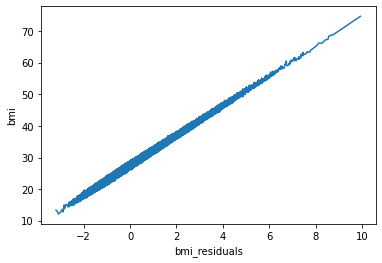

In [12]:
sns.lineplot(phenotype_df, x="bmi_residuals", y="bmi")

# Result 5

In [13]:
phenotype_df.groupby(["bmi_categories", "lf_combo"]).agg({"sample_names": len})

sample_names
bmi_categories lf_combo              
normal         False           137930
               True              1165
obese          False            88318
               True              7152
overweight     False           179371
               True              3535
severe obesity False             7036
               True               948
underweight    False             2169
               True                15

## Example combos

In [18]:
lf_rarecomb_combo_files = [
    "/data6/deepro/ukb_bmi/2_rarecomb/data/lifestyle_filtered/combo3.csv",
    "/data6/deepro/ukb_bmi/2_rarecomb/data/lifestyle_filtered/combo4.csv"
]

lf_rarecomb_combo_df = utpa.concat_multiple_combo_files(lf_rarecomb_combo_files)

In [21]:
lf_rarecomb_combo_df.sort_values("Case_Adj_Pval_bonf").head()

,Item_1,Item_2,Item_3,uniq_items,Case_Obs_Count_Combo,Case_Obs_Count_I1,Case_Obs_Count_I2,Case_Obs_Count_I3,Case_Exp_Prob_Combo,Case_Obs_Prob_Combo,...,Cont_Exp_Count_Combo,Effect_Size,Power_One_Pct,Power_Five_Pct,Case_Samples,Control_Samples,ngenes,Item_4,Case_Obs_Count_I4,Cont_Obs_Count_I4
646,Input_met,Input_IPP,Input_EIF2B3,Input_EIF2B3|Input_IPP|Input_met,13.0,16692,350,378,3.955812e-06,0.000158,...,0.269741,0.017074,0.888296,0.966628,4330655|3904241|1370660|3005569|1246427|445523...,5145894|5288329,2,NaN,NaN,NaN
19,Input_UGT2A2,Input_CEP290,Input_UGT2A1,Input_CEP290|Input_UGT2A1|Input_UGT2A2|Input_met,5.0,467,1111,575,1.083337e-07,0.000061,...,0.006902,0.015585,0.812398,0.933535,1225526|4230642|5284995|4986261|1968469,NaN,3,Input_met,16692.0,14357.0
1718,Input_met,Input_ZNF785,Input_HIRIP3,Input_HIRIP3|Input_ZNF785|Input_met,5.0,16692,111,72,2.389633e-07,0.000061,...,0.015562,0.015585,0.812398,0.933535,3300442|3842607|5122130|2715448|3667001,NaN,2,NaN,NaN,NaN
1394,Input_met,Input_MIPOL1,Input_NFKBIA,Input_MIPOL1|Input_NFKBIA|Input_met,5.0,16692,96,91,2.612092e-07,0.000061,...,0.015941,0.015585,0.812398,0.933535,1811472|1447992|1600711|3986579|4574095,NaN,2,NaN,NaN,NaN
413,Input_met,Input_OR3A2,Input_INCA1,Input_INCA1|Input_OR3A2|Input_met,5.0,16692,89,128,3.406244e-07,0.000061,...,0.023053,0.015585,0.812398,0.933535,5220053|4675275|3451881|2300511|1206321,NaN,2,NaN,NaN,NaN


In [25]:
lf_rarecomb_combo_df.sort_values("Effect_Size", ascending=False).head(25)

,Item_1,Item_2,Item_3,uniq_items,Case_Obs_Count_Combo,Case_Obs_Count_I1,Case_Obs_Count_I2,Case_Obs_Count_I3,Case_Exp_Prob_Combo,Case_Obs_Prob_Combo,...,Cont_Exp_Count_Combo,Effect_Size,Power_One_Pct,Power_Five_Pct,Case_Samples,Control_Samples,ngenes,Item_4,Case_Obs_Count_I4,Cont_Obs_Count_I4
15,Input_met,Input_MYH11,Input_DNAH3,Input_DNAH3|Input_MYH11|Input_met,20.0,16692,1566,2180,0.000102,0.000243,...,7.275412,0.025474,0.998978,0.999892,1586047|4034506|2463297|2276900|2763916|333090...,2418664,2,NaN,NaN,NaN
948,Input_met,Input_CCDC110,Input_TTN,Input_CCDC110|Input_TTN|Input_met,12.0,16692,226,5079,0.000034,0.000146,...,2.207608,0.024145,0.997352,0.999668,3480750|4498333|3205278|3125563|4619725|477976...,NaN,2,NaN,NaN,NaN
367,Input_LRP2,Input_met,Input_ATP12A,Input_ATP12A|Input_LRP2|Input_met,16.0,2712,16692,831,0.000067,0.000194,...,4.588839,0.022183,0.990680,0.998504,1212114|3862835|2026607|2082918|5981609|182196...,1740293,2,NaN,NaN,NaN
44,Input_met,Input_FBN3,Input_ACAA2,Input_ACAA2|Input_FBN3|Input_met,10.0,16692,2251,628,0.000042,0.000121,...,2.826904,0.022041,0.989859,0.998343,4491593|4309071|5923078|1895301|2279828|551263...,NaN,2,NaN,NaN,NaN
222,Input_LRP1B,Input_met,Input_SLC12A8,Input_LRP1B|Input_SLC12A8|Input_met,10.0,1607,16692,817,0.000039,0.000121,...,2.689531,0.022041,0.989859,0.998343,1960102|3222779|5111838|1989455|1474617|328434...,NaN,2,NaN,NaN,NaN
408,Input_SCN10A,Input_met,Input_ZFHX3,Input_SCN10A|Input_ZFHX3|Input_met,10.0,2039,16692,624,0.000038,0.000121,...,2.882981,0.022041,0.989859,0.998343,5990533|2880874|4007791|3312418|5805004|506191...,NaN,2,NaN,NaN,NaN
624,Input_met,Input_ATP1A4,Input_ATP8B3,Input_ATP1A4|Input_ATP8B3|Input_met,10.0,16692,1345,970,0.000039,0.000121,...,2.665770,0.022041,0.989859,0.998343,1486272|1777682|2730146|2147409|2616214|561713...,NaN,2,NaN,NaN,NaN
344,Input_MYO7A,Input_met,Input_TLE1,Input_MYO7A|Input_TLE1|Input_met,9.0,2819,16692,322,0.000027,0.000109,...,2.045216,0.020910,0.980763,0.996381,5123771|4399966|4984761|3524942|4046853|229815...,NaN,2,NaN,NaN,NaN
474,Input_SCN10A,Input_WDR31,Input_met,Input_SCN10A|Input_WDR31|Input_met,9.0,2039,257,16692,0.000016,0.000109,...,1.147186,0.020910,0.980763,0.996381,2764969|4753462|4007791|3488982|4562724|314300...,NaN,2,NaN,NaN,NaN
1231,Input_met,Input_TTN,Input_TCF21,Input_TCF21|Input_TTN|Input_met,9.0,16692,5079,165,0.000025,0.000109,...,1.760120,0.020910,0.980763,0.996381,2035752|1974321|1475756|5970512|4708096|289820...,NaN,2,NaN,NaN,NaN
